# Multi-group Agreement (Adult)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Adult
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from preprocess_data import preprocess_adult

# Adult Dataset
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [8]:
# Preprocess code outputs X, y, a transformer for X, and group membership
group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
X, y, col_transf, group_memberships = preprocess_adult()
num_groups = len(group_memberships)

% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


## Utilities for Training/Evaluation

In [9]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names):
    # Get test errors for each group
    test_err = {}
    std_errs = {}
    print("Group-conditional ERM Test Errors")
    for g in range(num_groups):
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        std_errs[g] = std_err(test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, test_err[g], std_errs[g], num_group_test[g], group_names[g]))

    print()

    erm_test_err = {}
    erm_std_errs = {}
    print("Overall ERM Test Errors")
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
        erm_std_errs[g] = std_err(erm_test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, erm_test_err[g], erm_std_errs[g], num_group_test[g], group_names[g]))

    return test_err, std_errs, erm_test_err, erm_std_errs
    
def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [10]:
XTICKS = ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)')
def plot_adult_agreements(ax, group_pairs_agreements, group_pairs, group_names, model_class, bar_width=0.2, bar_groups=4, xticks=XTICKS, legend=True):
       # Plot "agreement" for each pair of intersecting groups
       index = np.arange(bar_groups)
       num_group_pairs = len(group_pairs_agreements)

       for i in range(0, num_group_pairs, 3):
              ax.bar(i/(bar_groups - 1) - bar_width, 
                     group_pairs_agreements[i][0], bar_width,
                     yerr=group_pairs_agreements[i][1],
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i][0], group_names[group_pairs[i][0]], group_pairs[i][1], group_names[group_pairs[i][1]]))
              ax.bar(i/(bar_groups - 1), 
                     group_pairs_agreements[i+1][0], bar_width,
                     yerr=group_pairs_agreements[i+1][1],
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+1][0], group_names[group_pairs[i+1][0]],
                     group_pairs[i+1][1], 
                     group_names[group_pairs[i+1][1]]))
              ax.bar(i/(bar_groups - 1) + bar_width, 
                     group_pairs_agreements[i+2][0], bar_width,
                     yerr=group_pairs_agreements[i+2][1],
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+2][0], group_names[group_pairs[i+2][0]], group_pairs[i+2][1], group_names[group_pairs[i+2][1]]))

       ax.set_xlabel('Intersecting Group')
       ax.set_ylabel('Agreement')
       ax.set_title('Group Agreements ({})'.format(model_class))
       ax.set_xticks(index, xticks)
       if legend:
              ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                     fancybox=True, shadow=True, ncol=3)

def plot_adult_errors(ax, test_err, std_errs, erm_test_err, erm_std_errs, model_class, num_groups=num_groups, bar_width=0.2):
       # Error rate plots
       index = np.arange(num_groups)

       for g in range(num_groups):
              if g == 0:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, label="Group-ERM", color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, label="ERM", color="orange")
              else:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, color="orange")
              ax.set_ylabel('Group-conditional Error Rate')
              ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM ({})'.format(model_class))

       xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
       ax.set_xticks(index, xticks)
       ax.set_ylim([0, 0.5])
       ax.legend()

# Group Agreement

In [11]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

In [12]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [13]:
# Utility function for calculating group agreement
def group_agreement(pred, groups, group_pairs, group_pairs_cond):
    agreements = []
    for i, (g1, g2) in enumerate(group_pairs):
        intersection = group_pairs_cond[i]
        agree = np.sum(pred[g1][groups[intersection]] == pred[g2][groups[intersection]])/len(pred[0][groups[intersection]])
        agreements.append(agree)
    return agreements

In [14]:
# Generate 1000 bootstrap samples to get confidence intervals for agreement

# Get best parameterse from hyperparameter sweeps
SAVE_DATA_PATH = 'adult_agreement_data/'
dec_tree_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
with open(dec_tree_path, 'rb') as f:
        dec_tree_params = pickle.load(f)
logreg_params = {'max_iter': 250}
X_all = col_transf.transform(X)
assert(X_all.shape[0] == len(y))

# Wrap in a function to parallelize
def get_agreements():
    # Bootstrap from full dataset
    splits = resample(*tuple([X_all, y] + group_memberships), replace=True,
                    n_samples=X_all.shape[0])
    X_boot = splits[0]
    y_boot = splits[1]
    groups_boot = splits[2:]

    # Train-test split
    splits = train_test_split(*tuple([X_boot, y_boot] + groups_boot),
                            test_size=0.2, random_state=0)
    X_train_b = splits[0]
    X_test_b = splits[1]
    y_train_b = splits[2]
    y_test_b = splits[3]

    # group_train
    group_train_b = splits[4::2]
    group_test_b = splits[5::2]

    # Fit models
    logreg_models_b = {}
    dectree_models_b = {}
    tree_train_pred_b = {}
    tree_test_pred_b = {}
    logreg_train_pred_b = {}
    logreg_test_pred_b = {}
    for g in range(num_groups):
        # Fit and predict with decision trees
        dectree_models_b[g] = DecisionTreeClassifier(**dec_tree_params[g])
        dectree_models_b[g].fit(X_train_b[group_train_b[g]], 
                                y_train_b[group_train_b[g]])
        tree_train_pred_b[g] = dectree_models_b[g].predict(X_train_b)
        tree_test_pred_b[g] = dectree_models_b[g].predict(X_test_b)

        # Fit and predict with logistic regression
        logreg_models_b[g] = LogisticRegression()
        logreg_models_b[g].fit(X_train_b[group_train_b[g]], 
                                y_train_b[group_train_b[g]])
        logreg_train_pred_b[g] = logreg_models_b[g].predict(X_train_b)
        logreg_test_pred_b[g] = logreg_models_b[g].predict(X_test_b)

    # Calculate group agreements for each pair
    dt_train_agree = group_agreement(tree_train_pred_b, group_train_b,
                                    group_pairs, group_pairs_cond)
    lr_train_agree = group_agreement(logreg_train_pred_b, group_train_b,
                                    group_pairs, group_pairs_cond)
    dt_test_agree = group_agreement(tree_test_pred_b, group_test_b,
                                    group_pairs, group_pairs_cond)
    lr_test_agree = group_agreement(logreg_test_pred_b, group_test_b,
                                    group_pairs, group_pairs_cond)

    return dt_train_agree, lr_train_agree, dt_test_agree, lr_test_agree

In [18]:
# Run bootstraps in parallel
# Takes about 4.5 minutes
from multiprocessing import cpu_count
from joblib import Parallel, delayed

agree_path = 'final_agree/'
try:
    with open(os.path.join(agree_path, 'adult_dt_agree.pkl'), 'rb') as f:
        dt_train_agree_stats = pickle.load(f)
    with open(os.path.join(agree_path, 'adult_lr_agree.pkl'), 'rb') as f:
        lr_train_agree_stats = pickle.load(f)
except FileNotFoundError as err:
    n_bootstraps = 1000
    print("Bootstrap data for agreement does not exist! Running {} bootstraps".format(n_bootstraps))
    print("Number of CPUs: {}".format(cpu_count()))
    cpus = cpu_count()/2

    results = Parallel(n_jobs=-1)(delayed(get_agreements)() 
                                for _ in range(n_bootstraps))

    # Compile all bootstrap results
    dt_train_agree_all = [[] for _ in range(len(group_pairs))]
    lr_train_agree_all = [[] for _ in range(len(group_pairs))]
    dt_test_agree_all = [[] for _ in range(len(group_pairs))]
    lr_test_agree_all = [[] for _ in range(len(group_pairs))]
    for i in range(n_bootstraps):
        dt_train_agree, lr_train_agree, dt_test_agree, lr_test_agree = results[i]
        for j in range(len(group_pairs)):
            dt_train_agree_all[j].append(dt_train_agree[j])
            lr_train_agree_all[j].append(lr_train_agree[j])
            dt_test_agree_all[j].append(dt_test_agree[j])
            lr_test_agree_all[j].append(lr_test_agree[j])

    # Compute mean and standard errors
    dt_train_agree_stats = []
    lr_train_agree_stats = []
    dt_test_agree_stats = []
    lr_test_agree_stats = []
    for group_pair in range(len(group_pairs)):
        dt_train_agree_stats.append((np.mean(dt_train_agree_all[group_pair]),
                                    np.std(dt_train_agree_all[group_pair])))
        lr_train_agree_stats.append((np.mean(lr_train_agree_all[group_pair]),
                                    np.std(lr_train_agree_all[group_pair])))
        dt_test_agree_stats.append((np.mean(dt_test_agree_all[group_pair]),
                                    np.std(dt_test_agree_all[group_pair])))
        lr_test_agree_stats.append((np.mean(lr_test_agree_all[group_pair]),
                                    np.std(lr_test_agree_all[group_pair])))
    
    # Save the agreement stats
    dt_agree_path = os.path.join(agree_path, 'adult_dt_agree.pkl')
    with open(dt_agree_path, 'wb') as handle:
        pickle.dump(dt_train_agree_stats, handle, 
                    protocol=pickle.HIGHEST_PROTOCOL)
    lr_agree_path = os.path.join(agree_path, 'adult_lr_agree.pkl')
    with open(lr_agree_path, 'wb') as handle:
        pickle.dump(lr_train_agree_stats, handle, 
                    protocol=pickle.HIGHEST_PROTOCOL)

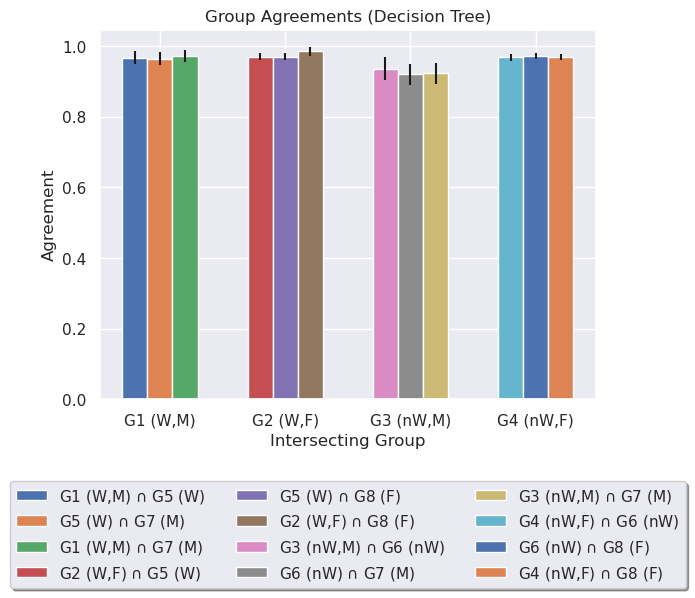

In [19]:
# Plot group-conditional agreements
fig, ax = plt.subplots()
plot_adult_agreements(ax, dt_train_agree_stats, 
                      group_pairs, group_names, 
                      model_class="Decision Tree")

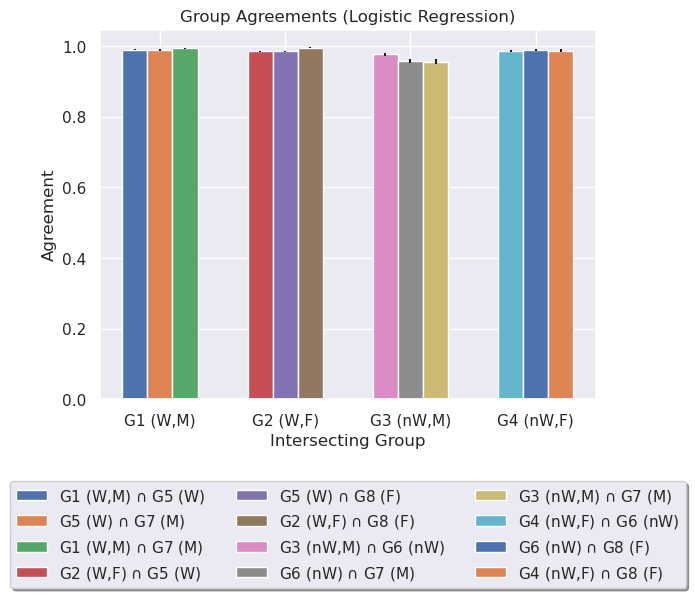

In [20]:
# Plot group-conditional agreements
fig, ax = plt.subplots()
plot_adult_agreements(ax, lr_train_agree_stats, 
                      group_pairs, group_names, 
                      model_class="Logistic Regression")

# Comparison: Per-group ERM (Random Forest) vs. Ensemble Methods (Trees)

In [21]:
# Get best parameters for each model
SAVE_DATA_PATH = 'adult_agreement_data/'
with open(os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl'), 'rb') as f:
    dt_params = pickle.load(f)
with open(os.path.join(SAVE_DATA_PATH, 'rf_params.pkl'), 'rb') as f:
    rf_params = pickle.load(f)
with open(os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl'), 'rb') as f:
    gb_params = pickle.load(f)
with open(os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl'), 'rb') as f:
    xgb_params = pickle.load(f)

In [23]:
# All the experiments for this part are done in bootstrap_errs.py
RESULTS_PATH = 'final_errs/'
with open(os.path.join(RESULTS_PATH, 'adult_dt_errs.pkl'), 'rb') as f:
    dt_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, 'adult_dt_erm_errs.pkl'), 'rb') as f:
    dt_erm_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, 'adult_rf_errs.pkl'), 'rb') as f:
    rf_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, 'adult_gb_errs.pkl'), 'rb') as f:
    gb_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, 'adult_xgb_errs.pkl'), 'rb') as f:
    xgb_errs_stats = pickle.load(f)

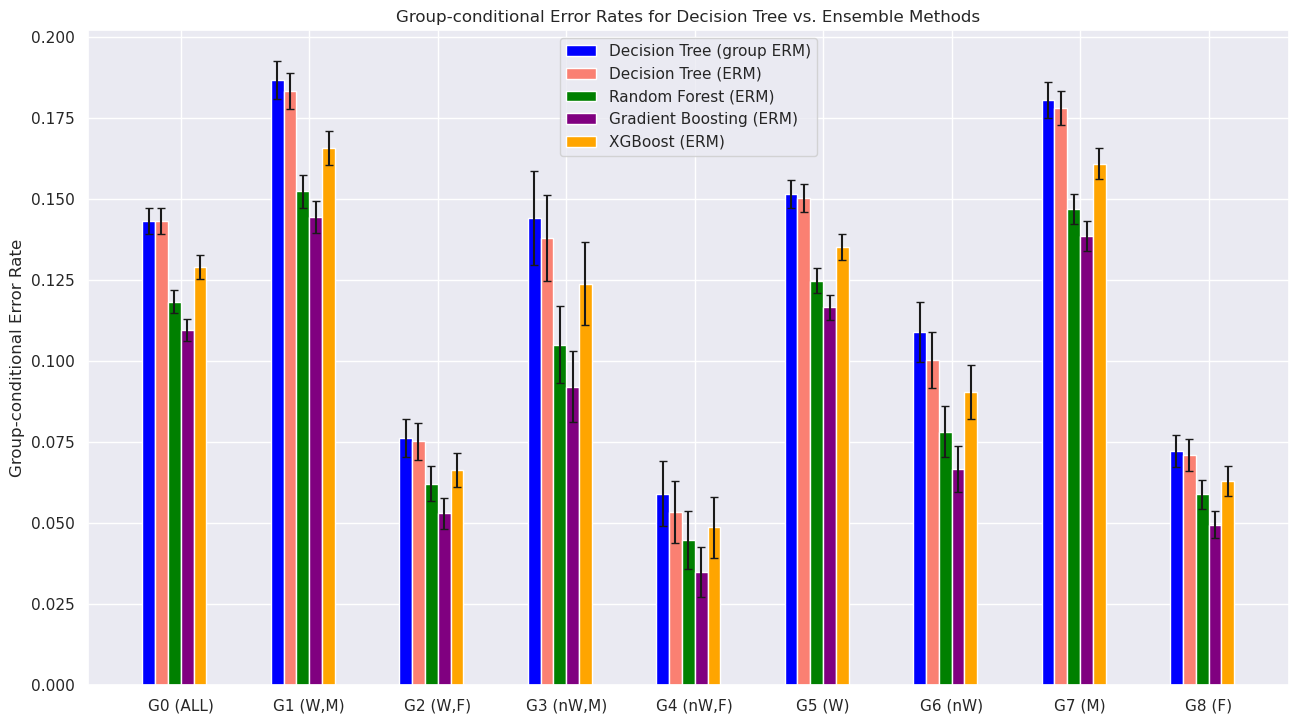

In [24]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, dt_errs_stats[g][0], bar_width, yerr=dt_errs_stats[g][1], capsize=3, label="Decision Tree (group ERM)",
        color="blue")
        ax.bar(g - 1.5 * bar_width, dt_erm_errs_stats[g][0], bar_width, yerr=dt_erm_errs_stats[g][1], capsize=3, label="Decision Tree (ERM)", color="salmon")
        ax.bar(g - 0.5 * bar_width, rf_errs_stats[g][0], bar_width, yerr=rf_errs_stats[g][1], capsize=3, label="Random Forest (ERM)", color="green")
        ax.bar(g + 0.5 * bar_width, gb_errs_stats[g][0], bar_width, yerr=gb_errs_stats[g][1], capsize=3, label="Gradient Boosting (ERM)", color="purple")
        ax.bar(g + 1.5 * bar_width, xgb_errs_stats[g][0], bar_width, yerr=xgb_errs_stats[g][1], capsize=3, label="XGBoost (ERM)", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, dt_errs_stats[g][0], bar_width, yerr=dt_errs_stats[g][1], capsize=3, color="blue")
        ax.bar(g - 1.5 * bar_width, dt_erm_errs_stats[g][0], bar_width, yerr=dt_erm_errs_stats[g][1], capsize=3, color="salmon")
        ax.bar(g - 0.5 * bar_width, rf_errs_stats[g][0], bar_width, yerr=rf_errs_stats[g][1], capsize=3, color="green")
        ax.bar(g + 0.5 * bar_width, gb_errs_stats[g][0], bar_width, yerr=gb_errs_stats[g][1], capsize=3, color="purple")
        ax.bar(g + 1.5 * bar_width, xgb_errs_stats[g][0], bar_width, yerr=xgb_errs_stats[g][1], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for Decision Tree vs. Ensemble Methods')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()